In [ ]:
import os
import gym
import imageio
import pybullet_envs
import PIL.Image
import pybullet
import pybullet_data

In [ ]:
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
env = gym.make('HumanoidBulletEnv-v0')
# env.render(mode='human')
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))



In [ ]:
done = False
video_filename = 'humanoid_gym.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    while not done:
        state, reward, done, info = env.step(env.action_space.sample())
        video.append_data(env.render(mode='rgb_array'))
env.reset()

In [1]:
# Pybullet testing environment
import PIL.Image
import os
# Important: pybullet should be charged only once !!
from tf_agents.environments import suite_pybullet, parallel_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.trajectories.trajectory import Trajectory
from tf_agents.networks import actor_distribution_network
from tf_agents.drivers import dynamic_episode_driver, dynamic_step_driver
from tf_agents.policies import random_tf_policy
import tensorflow as tf

/home/florent/anaconda3/envs/vae_mdp/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


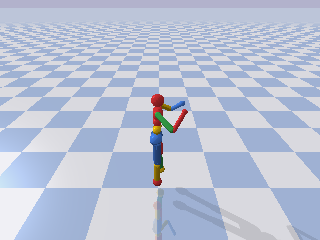

In [2]:
py_env = suite_pybullet.load('HumanoidBulletEnv-v0')
py_env.render(mode='human')
py_env.reset()
PIL.Image.fromarray(py_env.render())

In [43]:
bad_state_detection = lambda trajectory: print("bad state!: {}".format(trajectory.observation[0][0] + 0.8))\
    if trajectory.observation[0][0] + 0.8 <= 0.78 else None
tf_env = tf_py_environment.TFPyEnvironment(py_env)
stochastic_policy_dir = '/home/florent/Documents/hpc-cluster/saves/stochastic_policy/permissive_variance_policy'
policy = tf.compat.v2.saved_model.load(stochastic_policy_dir)
dynamic_episode_driver.DynamicEpisodeDriver(tf_env, policy, num_episodes=15, observers=[bad_state_detection]).run()



bad state!: 0.7644143104553223
bad state!: 0.7669100761413574
bad state!: 0.7689265012741089
bad state!: 0.7715256214141846
bad state!: 0.7759760618209839
bad state!: 0.7670365571975708
bad state!: 0.763435959815979
bad state!: 0.7604746222496033
bad state!: 0.756405770778656
bad state!: 0.7520368695259094
bad state!: 0.7748213410377502


(TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 44), dtype=float32, numpy=
 array([[ 5.99999964e-01,  7.11754046e-06,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00,  6.08818755e-02,
          0.00000000e+00,  4.38749433e-01,  0.00000000e+00,
         -9.28759202e-02,  0.00000000e+00,  1.01374447e+00,
          0.00000000e+00,  2.75345892e-01,  0.00000000e+00,
          6.98572040e-01,  0.00000000e+00,  1.06552875e+00,
          0.00000000e+00,  1.02481306e+00,  0.00000000e+00,
          2.89953083e-01,  0.00000000e+00,  7.16565192e-01,
          0.00000000e+00,  1.04809713e+00,  0.00000000e+00,
          2.39592999e-01,  0.00000000e+00,  2.11571410e-01,
          0.00000000e+00, 

In [ ]:
# Parallel environments.
num_parallel_environments = 4
tf_env = tf_py_environment.TFPyEnvironment(parallel_py_environment.ParallelPyEnvironment(
    [lambda : suite_pybullet.load('HumanoidBulletEnv-v0')] * num_parallel_environments))
tf_env.reset()

In [ ]:
replay_buffer_size = 12800

# create a dataset
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
actor_net = actor_distribution_network.ActorDistributionNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(128, 128))
policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
train_step_counter = tf.compat.v2.Variable(0)

agent = reinforce_agent.ReinforceAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    actor_network=actor_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4),
    normalize_returns=True,
    train_step_counter=train_step_counter)
agent.initialize()

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_size)
dataset = replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=replay_buffer_size, num_steps=3)

random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
dynamic_step_driver.DynamicStepDriver(tf_env, random_policy,
                                      observers=[replay_buffer.add_batch], num_steps=replay_buffer_size).run()


In [ ]:
def labeling_function(states):
    return states.take(0, axis=-1) + 0.8 <= 0.78

In [ ]:
import h5py
import tf_agents.trajectories.time_step as ts
import datetime

dataset_path = 'dataset'
iterator = iter(dataset)
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
with h5py.File(dataset_path + '/rl_exploration' + current_time + '.hdf5', 'w') as h5f:
    data = iterator.next()[0]
    states = data.observation[:, :2, :].numpy()
    actions = data.action[:, :2, :].numpy()
    rewards = data.reward[:, :2].numpy()
    next_states = data.observation[:, 1:, :].numpy()
    next_labels = labeling_function(next_states)
    # 0: initial state; 1: mid state; 2: terminal state
    state_type = data.step_type[:, :2].numpy()
    next_state_type = data.next_step_type[:, :2].numpy()

    # remove transitions where the incident state is terminal and next state is initial
    filtering = state_type[:, 0] != ts.StepType.LAST
    filtering &= state_type[:, 1] != ts.StepType.LAST
    filtering &= next_state_type[:, 0] != ts.StepType.FIRST
    filtering &= next_state_type[:, 1] != ts.StepType.FIRST

    h5f['state'] = states[filtering]
    h5f['action'] = actions[filtering]
    h5f['reward'] = rewards[filtering]
    h5f['next_state'] = next_states[filtering]
    h5f['next_state_label'] = next_labels[filtering]
    # 0: initial state; 1: mid state; 2: terminal state
    h5f['state_type'] = state_type[filtering]
    h5f['next_state_type'] = state_type[filtering]

In [ ]:
from typing import List, Dict, Tuple
import glob
import os

file_list: List[str] = glob.glob(os.path.join(dataset_path, 'rl_*')) + \
                       glob.glob(os.path.join(dataset_path, 'reinforcement_learning', 'rl_*'))
print("File list:")
print(file_list)

length: int = 0
h5f_indices: Dict[str, Tuple[int, int]] = {}
shape: Dict[str, Tuple[int, ...]] = {}
dataset_name = 'rl_observation_dataset.hdf5'

for h5f_name in file_list:
    with h5py.File(h5f_name, 'r') as h5f:
        h5f_length = h5f['state'].shape[0]  # we assume that all h5f datasets have the same length (= size of axis 0)
        h5f_indices[h5f_name] = (length, length + h5f_length)
        length += h5f_length

for i, h5f_name in enumerate(file_list):
    with h5py.File(h5f_name, 'r') as h5f:
        with h5py.File(os.path.join(dataset_path, dataset), 'w') as merged_h5f:
            for key in h5f:
                if i == 0:  # dataset file initialization
                    shape[key] = (length, ) + h5f[key].shape[1:]
                    merged_h5f.create_dataset(key, shape[key], dtype=h5f[key].dtype)
                first, last = h5f_indices[h5f_name]
                merged_h5f[key][first: last] = h5f[key]

print("Dataset files merged")

In [ ]:
class generator:
    def __init__(self, file):
        self.file = file

    def __call__(self):
        with h5py.File(self.file, 'r') as hf:
            for (state, action, reward, next_state, label, state_type, next_state_type) in \
                zip(hf['state'], hf['action'], hf['reward'], hf['next_state'],
                    hf['next_state_label'], hf['state_type'], hf['next_state_type']):
                yield state, action, reward, next_state, label, state_type, next_state_type

    def get_tensor_shape(self):
        with h5py.File(self.file, 'r') as hf:
           return (tf.TensorShape(hf['state'].shape[1:]),
                   tf.TensorShape(hf['action'].shape[1:]),
                   tf.TensorShape(hf['reward'].shape[1:]),
                   tf.TensorShape(hf['next_state'].shape[1:]),
                   tf.TensorShape(hf['next_state_label'].shape[1:]),
                   tf.TensorShape(hf['state_type'].shape[1:]),
                   tf.TensorShape(hf['next_state_type'].shape[1:]))

gen = generator(dataset_path + '/rl_exploration.hdf5')
loaded_dataset = tf.data.Dataset.from_generator(gen,
                                                (tf.float32, tf.float32, tf.float32, tf.float32, tf.bool, tf.int8, tf.int8),
                                                gen.get_tensor_shape())

In [ ]:
for state, action, reward, next_state, label, state_type, next_state_type in loaded_dataset:
    if label[0]:
        print(label[0], next_state[0], next_state_type)
    if label[1]:
        print(label[1], next_state[1], next_state_type)
    if state_type[0] == ts.StepType.LAST:
        print("BAD STATE S0:", state[0])
    if state_type[1] == ts.StepType.LAST:
        print("BAD STATE S0:", state[1])


In [ ]:
ts.StepType.FIRST # initial state
ts.StepType.LAST # terminal state
ts.StepType.MID # normal state

In [ ]:
x = data.step_type[:, 0] != ts.StepType.LAST
x &= data.step_type[:, 1] != ts.StepType.LAST
x.numpy()

In [ ]:
y = data.observation[:, :2, :].numpy()
z = y[x]
z